In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
from scipy.interpolate import griddata
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

In [3]:
np.random.seed(1234)
tf.set_random_seed(1234)

In [4]:
class PINN:
    def __init__(self, x, t, D, layers, activation, lr):
        self.x = x
        self.t = t
        self.D = D
        self.lr = lr
        self.activation = activation
        self.loss_log = []

        self.weights, self.biases = self.initilize_NN(layers)
        self.sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
        self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x.shape[1]])
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]])

        self.surrogate_u = self.surrogate(self.x_tf, self.t_tf)
        self.residual    = self.residual_net(self.surrogate_u, self.x_tf, self.t_tf)
        self.loss        = tf.reduce_mean(tf.square(self.residual))

        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.lr).minimize(self.loss)
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initilize_NN(self, layers):
        weights = []
        biases  = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

    def neural_net(self, X, weights, biases, activation):
        num_layers = len(weights) + 1
        H = X
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            H = activation(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    def net_u(self, x, t):
        u = self.neural_net(tf.concat([x, t], 1), self.weights, self.biases, self.activation)
        return u

    def surrogate(self, x, t):
        rhs  = tf.sin(8*x) / 8
        for i in range(1, 5):
            rhs += tf.sin(i*x) / i
        return (x**2 - np.pi**2)*(1-np.e**-t)*self.net_u(x, t) + rhs

    def R(self, x, t):
        return np.e**(-t)*(3/2*tf.sin(2*x)+8/3*tf.sin(3*x)+15/4*tf.sin(4*x)+63/8*tf.sin(8*x))

    def residual_net(self, u, x, t):
        u_x  = tf.gradients(u, x)[0]
        u_t  = tf.gradients(u, t)[0]
        u_xx = tf.gradients(u_x, x)[0]
        return self.D*u_xx + self.R(x, t) - u_t

    def callback(self, loss, res, deriv):
        print('Loss:%f,res:%f,deriv:%f'%(loss, res, deriv))

    def train(self, max_iter=40000):
        loss_value = np.inf
        for iter in range(max_iter):
            tf_dict = {
                self.x_tf:self.x,
                self.t_tf:self.t
            }
            _, loss_value = self.sess.run([self.optimizer,
                self.loss], tf_dict)
            if iter % 1000 == 0:
                print("第%d次 %f"%(iter, loss_value))
        print("第%d次的损失为%f"%(max_iter, loss_value))

    def predict(self, X_star, T_star):
        u_star = self.sess.run(self.surrogate_u, {self.x_tf: X_star, self.t_tf:T_star})
        return u_star

In [5]:
def train_model(train_num):
    x = np.linspace(-np.pi, np.pi, train_num)[:, None]
    t = np.linspace(0, 1, train_num)[:, None]
    X, T = np.meshgrid(x, t)
    x = X.flatten()[:, None]
    t = T.flatten()[:, None]
    start_time = time.time()
    PINN_tanh = PINN(x, t, D, layers, activation, lr)
    print("Start training! train_num:%d"%(train_num))
    PINN_tanh.train(iterations)
    elapsed = time.time() - start_time
    print('Training time: %.4f' % (elapsed))
    return PINN_tanh

In [6]:
def compute_error(model, test_num):
    x_test = np.linspace(-np.pi, np.pi, test_num)[:, None]
    t_test = np.linspace(0, 1, test_num)[:, None]
    X, T = np.meshgrid(x_test, t_test)
    x_test = X.flatten()[:, None]
    t_test = T.flatten()[:, None]
    u_test  = np.sin(8*x_test)/8
    for i in range(1, 5):
        u_test += np.sin(i*x_test) / i
    u_test  *= np.e**(-t_test)
    u_pred   = model.predict(x_test, t_test)
    L2_norm  = np.linalg.norm(u_test-u_pred,2)/np.linalg.norm(u_test,2)
    return L2_norm

In [7]:
layers = [2, 20, 20, 20, 20, 1]
activation = tf.tanh
lr = 1e-4
iterations = 100000
D = 1

In [7]:
train_nums = np.array([5, 6, 7, 8, 9, 10, 11])
test_num   = 100
errors     = []
for train_num in train_nums:
    model = train_model(train_num)
    error = compute_error(model, test_num)
    print("train_num:%d, error:%f"%(train_num, error))
    errors.append(error)
errors = np.array(errors)
np.save('errors_PINN.npy', errors)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Start training! train_num:5
第0次 0.561683
第1000次 0.004420
第2000次 0.000255
第3000次 0.000168
第4000次 0.000118
第5000次 0.000071
第6000次 0.000035
第7000次 0.000015
第8000次 0.000006
第9000次 0.000003
第10000次 0.000002
第11000次 0.000002
第12000次 0.000001
第13000次 0.000002
第14000次 0.000001
第15000次 0.000006
第16000次 0.000002
第17000次 0.000001
第18000次 0.000001
第19000次 0.000001
第20000次 0.000001
第21000次 0.000001
第22000次 0.000001
第23000次 0.000001
第24000次 0.000004
第25000次 0.000001
第26000次 0.000001
第27000次 0.000011
第28000次 0.000001
第29000次 0.000001
第30000次 0.000002
第31000次 0.000002
第32000次 0.000001
第33000次 0.000001
第34000次 0.000001
第35000次 0.000000
第36000次 0.000001
第37000次 0.000001
第38000次 0.000000
第39000次 0.000000
第40000次 0.000001
第41000次 0.000000
第42000次 0.000000
第43000次 0.000000
第44000次 0.000000
第45000次 0.000000
第46000次 0.000000
第47000次 0.000000
第48000次 0.000000
第49000次 0.000000
第50000次 0.000000
第51000次 0.000001
第52000次

In [ ]:

errors_gNN = np.load('errors_gPINN.npy')
errors_NN = np.load('errors_PINN.npy')

plt.plot(train_nums**2, errors_NN, 'b-', label='PINN')
plt.plot(train_nums**2, errors_gNN, 'r-', label='gPINN w=0.01')
plt.yscale('log')
plt.tight_layout()
plt.legend()
plt.savefig('Comparison between NN and gNN L2.pdf')
plt.show()

In [12]:
x = np.linspace(-np.pi, np.pi, 10)[:, None]
t = np.linspace(0, 1, 5)[:, None]
X, T = np.meshgrid(x, t)
x = X.flatten()[:, None]
t = T.flatten()[:, None]
start_time = time.time()
PINN_tanh = PINN(x, t, D, layers, activation, lr)
print("Start training!")
PINN_tanh.train(iterations)
elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Start training!
第0次 8.743793
第1000次 1.069892
第2000次 0.068437
第3000次 0.014541
第4000次 0.008694
第5000次 0.005110
第6000次 0.002832
第7000次 0.001354
第8000次 0.000618
第9000次 0.000424
第10000次 0.000339
第11000次 0.000244
第12000次 0.000195
第13000次 0.000158
第14000次 0.000131
第15000次 0.000135
第16000次 0.000100
第17000次 0.000094
第18000次 0.000084
第19000次 0.000078
第20000次 0.000085
第21000次 0.000071
第22000次 0.000068
第23000次 0.000065
第24000次 0.000065
第25000次 0.000060
第26000次 0.000059
第27000次 0.000055
第28000次 0.000054
第29000次 0.000053
第30000次 0.000050
第31000次 0.000048
第32000次 0.000047
第33000次 0.000045
第34000次 0.000044
第35000次 0.000042
第36000次 0.000054
第37000次 0.000040
第38000次 0.000038
第39000次 0.000037
第40000次 0.000036
第41000次 0.000038
第42000次 0.000051
第43000次 0.000033
第44000次 0.000032
第45000次 0.000031
第46000次 0.000030
第47000次 0.000029
第48000次 0.000044
第49000次 0.000027
第50000次 0.000026
第51000次 0.000025
第52000次 0.000026
第5

In [60]:
x_num = 400
t_num = 200
x_test = np.linspace(-np.pi, np.pi, x_num)[:, None]
t_test = np.linspace(0, 1, t_num)[:, None]
X, T = np.meshgrid(x_test, t_test)
x_test = X.flatten()[:, None]
t_test = T.flatten()[:, None]
u_test  = np.sin(8*x_test)/8
for i in range(1, 5):
    u_test += np.sin(i*x_test) / i
u_test  *= np.e**(-t_test)

In [61]:
# t -> [0, 1] : x -> [-pi, pi]
u_pred = PINN_tanh.predict(x_test, t_test)
L2_norm  = np.linalg.norm(u_test-u_pred,2)/np.linalg.norm(u_test,2)
print(L2_norm)

1.3275156025771777


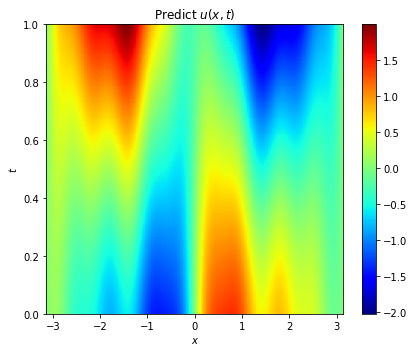

In [62]:
u_test = np.reshape(u_test, (t_num, x_num))
u_pred = np.reshape(u_pred, (t_num, x_num))
fig = plt.figure(figsize=(6,5))
plt.pcolor(X, T, u_pred, cmap='jet')
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Predict $u(x,t)$')
plt.colorbar()
plt.tight_layout()
plt.savefig('Pred s.pdf')

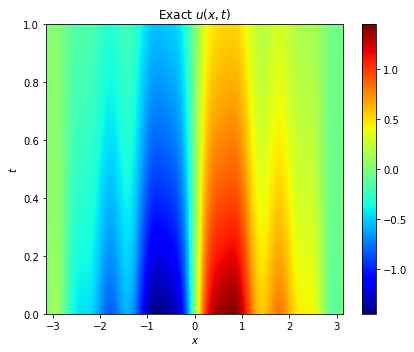

In [63]:
fig = plt.figure(figsize=(6,5))
plt.pcolor(X, T, u_test, cmap='jet')
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Exact $u(x,t)$')
plt.colorbar()
plt.tight_layout()
plt.savefig('Exact s.pdf')